In [1]:
setwd('/import/hd/sc')

In [2]:
mac = readRDS('./scRNA.macro.rds')

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)



In [3]:
table(mac$celltype)


      Granulo Inflamm.Macro          MAST          Mono     Resid.mac 
          372          1142            36          2700          3056 
     SPP1_mac          cDC1          cDC2 
          242            60          1142 

In [4]:
fib = readRDS('./scRNA.fibro2.rds')

In [33]:
fib$celltype = 'fib'

In [34]:
sce = merge(fib,mac)

In [35]:
saveRDS(sce,file = 'merged.fib.mac.rds')

In [36]:
table(sce$celltype)


      Granulo Inflamm.Macro          MAST          Mono     Resid.mac 
          372          1142            36          2700          3056 
     SPP1_mac          cDC1          cDC2           fib 
          242            60          1142         15217 

In [37]:
library(CellChat)
library(patchwork)

In [38]:
packageVersion('CellChat')

[1] '2.1.2'

In [39]:
library(Seurat)

In [40]:
cellchat <- createCellChat(object = sce,
                           meta = sce@meta.data,
                           group.by = "celltype")
cellchat

CellChatDB <- CellChatDB.human
CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling") 
# set the used database in the object
cellchat@DB <- CellChatDB.use

library(future)
cellchat <- subsetData(cellchat) 
# do parallel ，根据配置设置
plan(multisession, workers=20)
cellchat <- identifyOverExpressedGenes(cellchat)
#识别过表达配体受体对
cellchat <- identifyOverExpressedInteractions(cellchat)

[1] "Create a CellChat object from a Seurat object"
The `data` slot in the default assay is used. The default assay is RNA 
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  Granulo, Inflamm.Macro, MAST, Mono, Resid.mac, SPP1_mac, cDC1, cDC2, fib 


An object of class CellChat created from a single dataset 
 21825 genes.
 23967 cells. 
CellChat analysis of single cell RNA-seq data! 

The number of highly variable ligand-receptor pairs used for signaling inference is 763 


In [41]:
#project gene expression data onto PPI (Optional: when running it, USER should set `raw.use = FALSE` in the function `computeCommunProb()` in order to use the projected data)
cellchat <- smoothData(cellchat, adj = PPI.human)
#cellchat <- projectData(cellchat, PPI.human)
library(future)
options(future.globals.maxSize= 4000000000)
cellchat <- computeCommunProb(cellchat, raw.use = TRUE, population.size = TRUE) 
# Filter out the cell-cell communication if there are only few number of cells in certain cell groups
cellchat <- filterCommunication(cellchat, min.cells = 3)
df.net <- subsetCommunication(cellchat,slot.name = "netP")

triMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2024-08-08 13:44:26]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2024-08-08 13:51:44]"


In [42]:
cellchat <- computeCommunProbPathway(cellchat)

cellchat <- aggregateNet(cellchat)

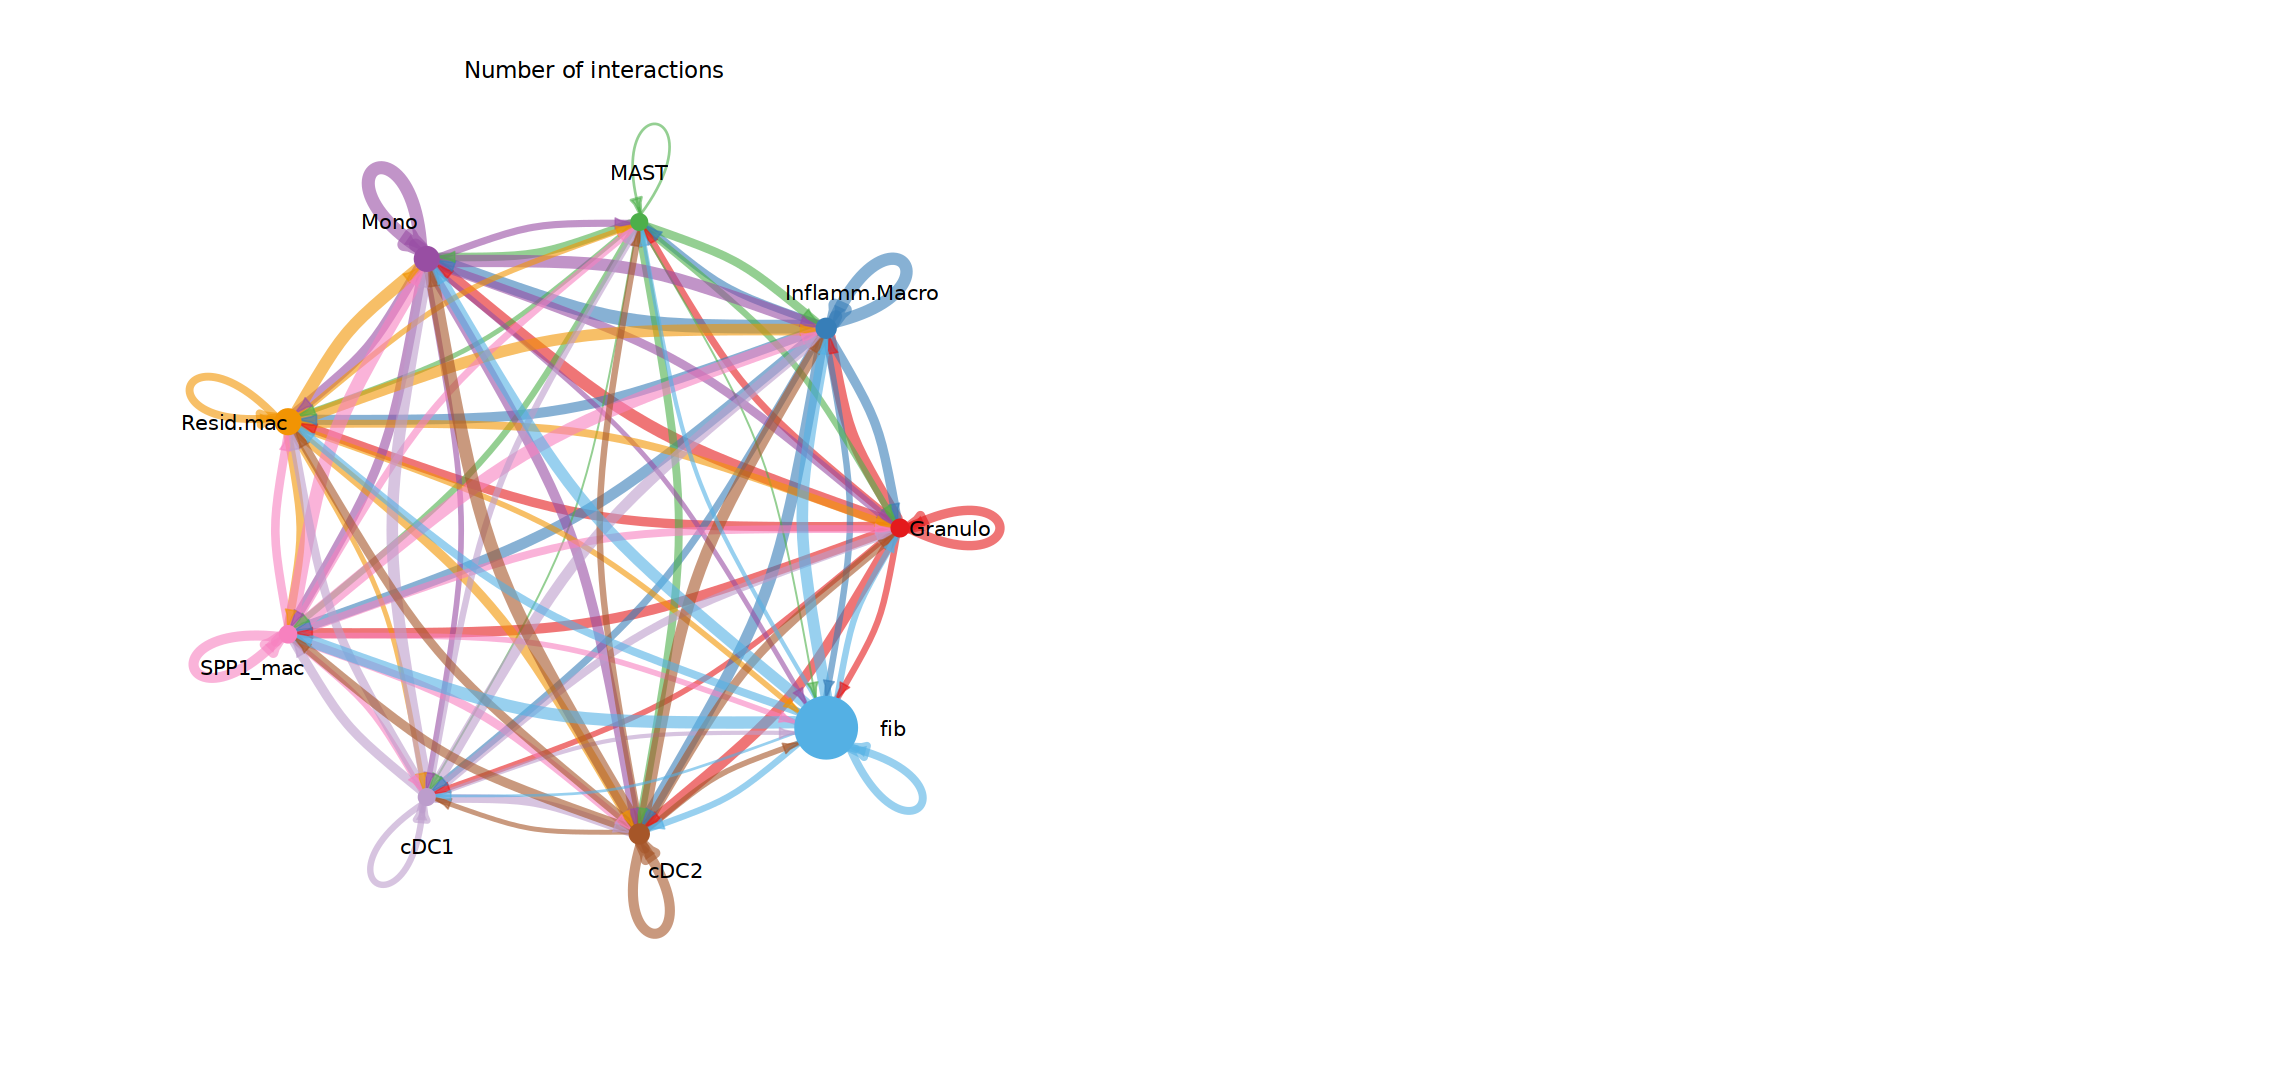

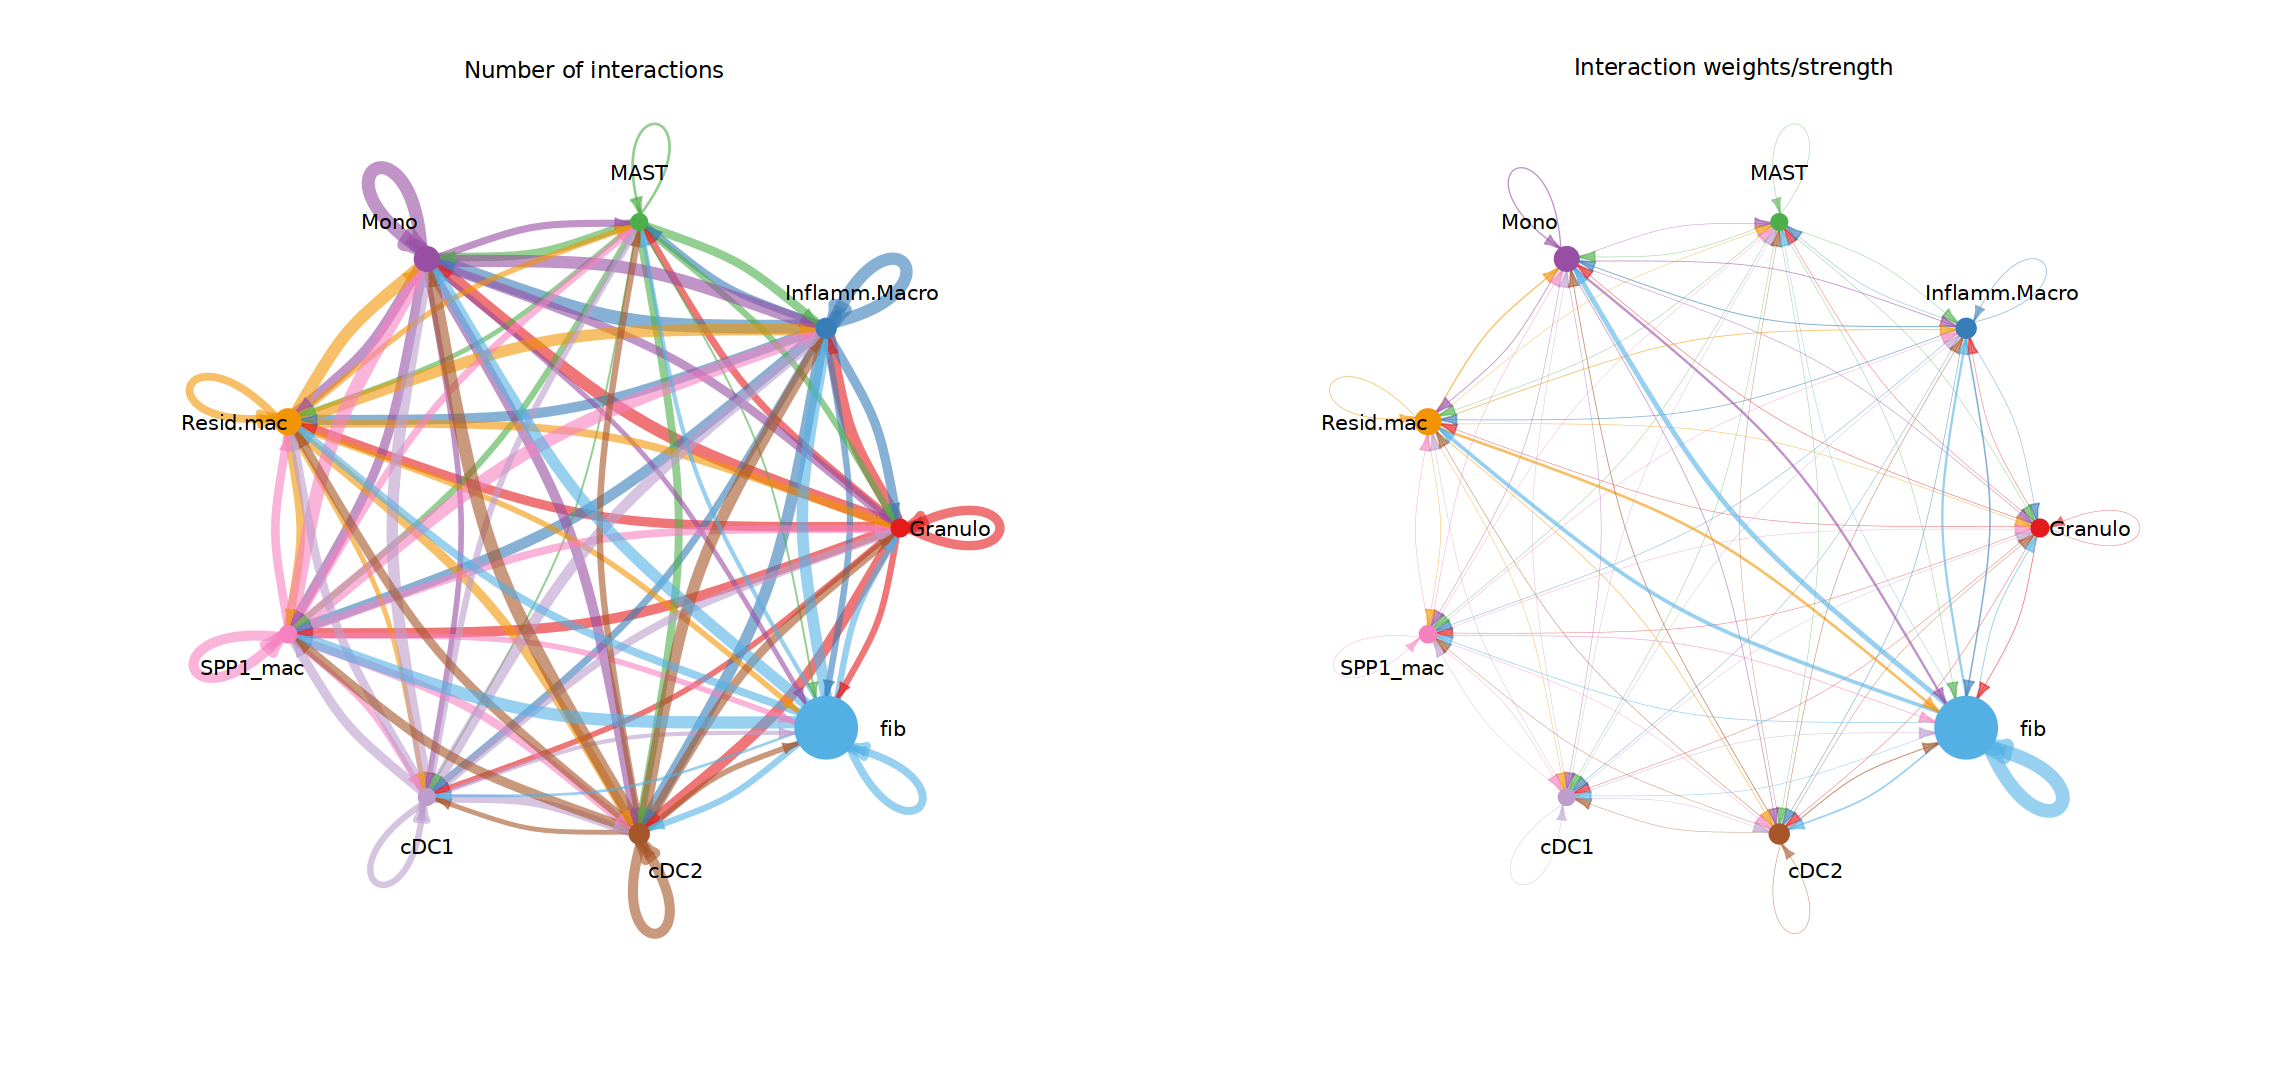

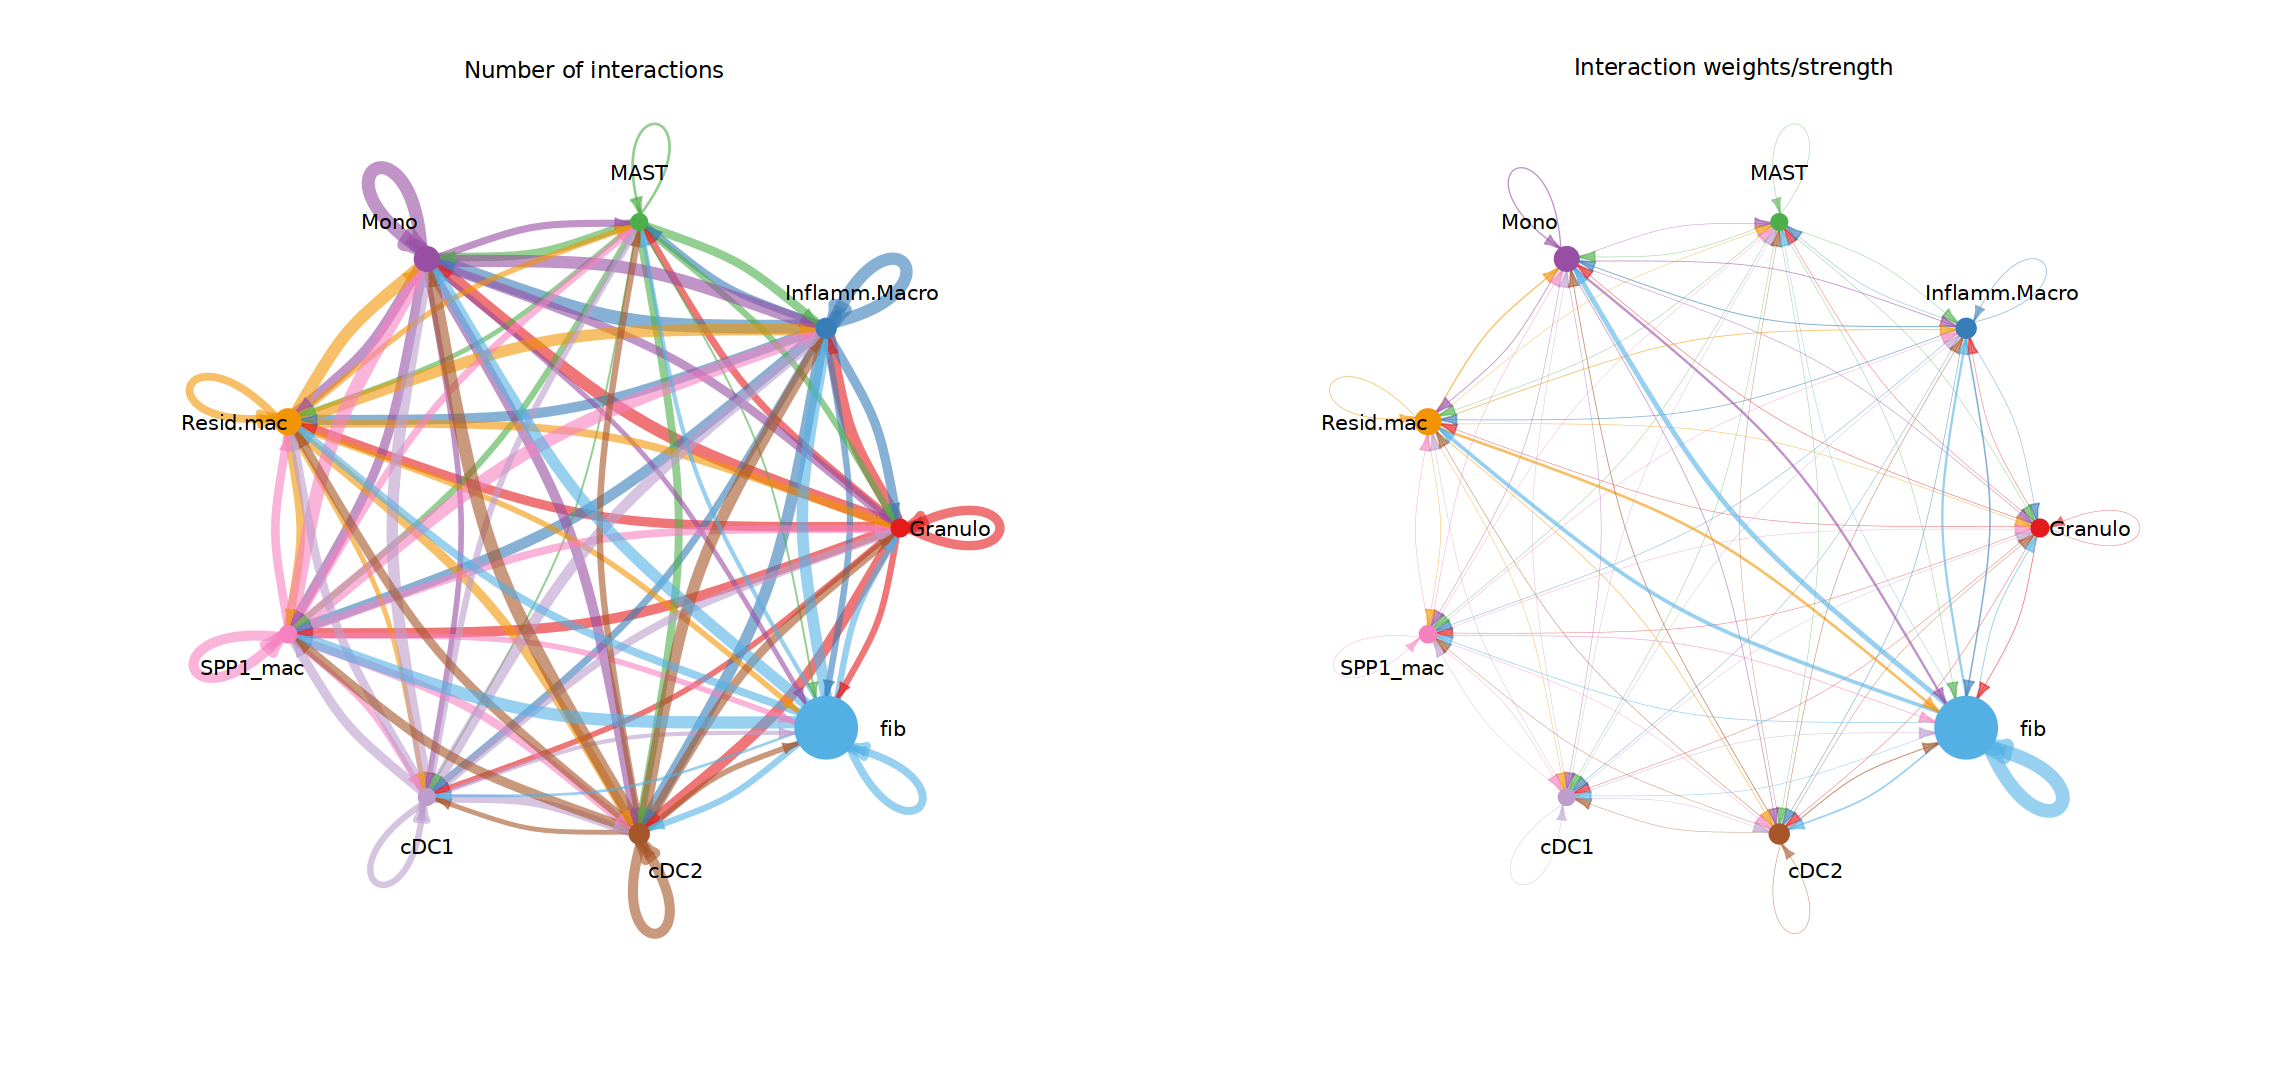

In [43]:
groupSize <- as.numeric(table(cellchat@idents))
par(mfrow = c(1,2), xpd=TRUE)
netVisual_circle(cellchat@net$count, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Number of interactions")
netVisual_circle(cellchat@net$weight, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Interaction weights/strength")

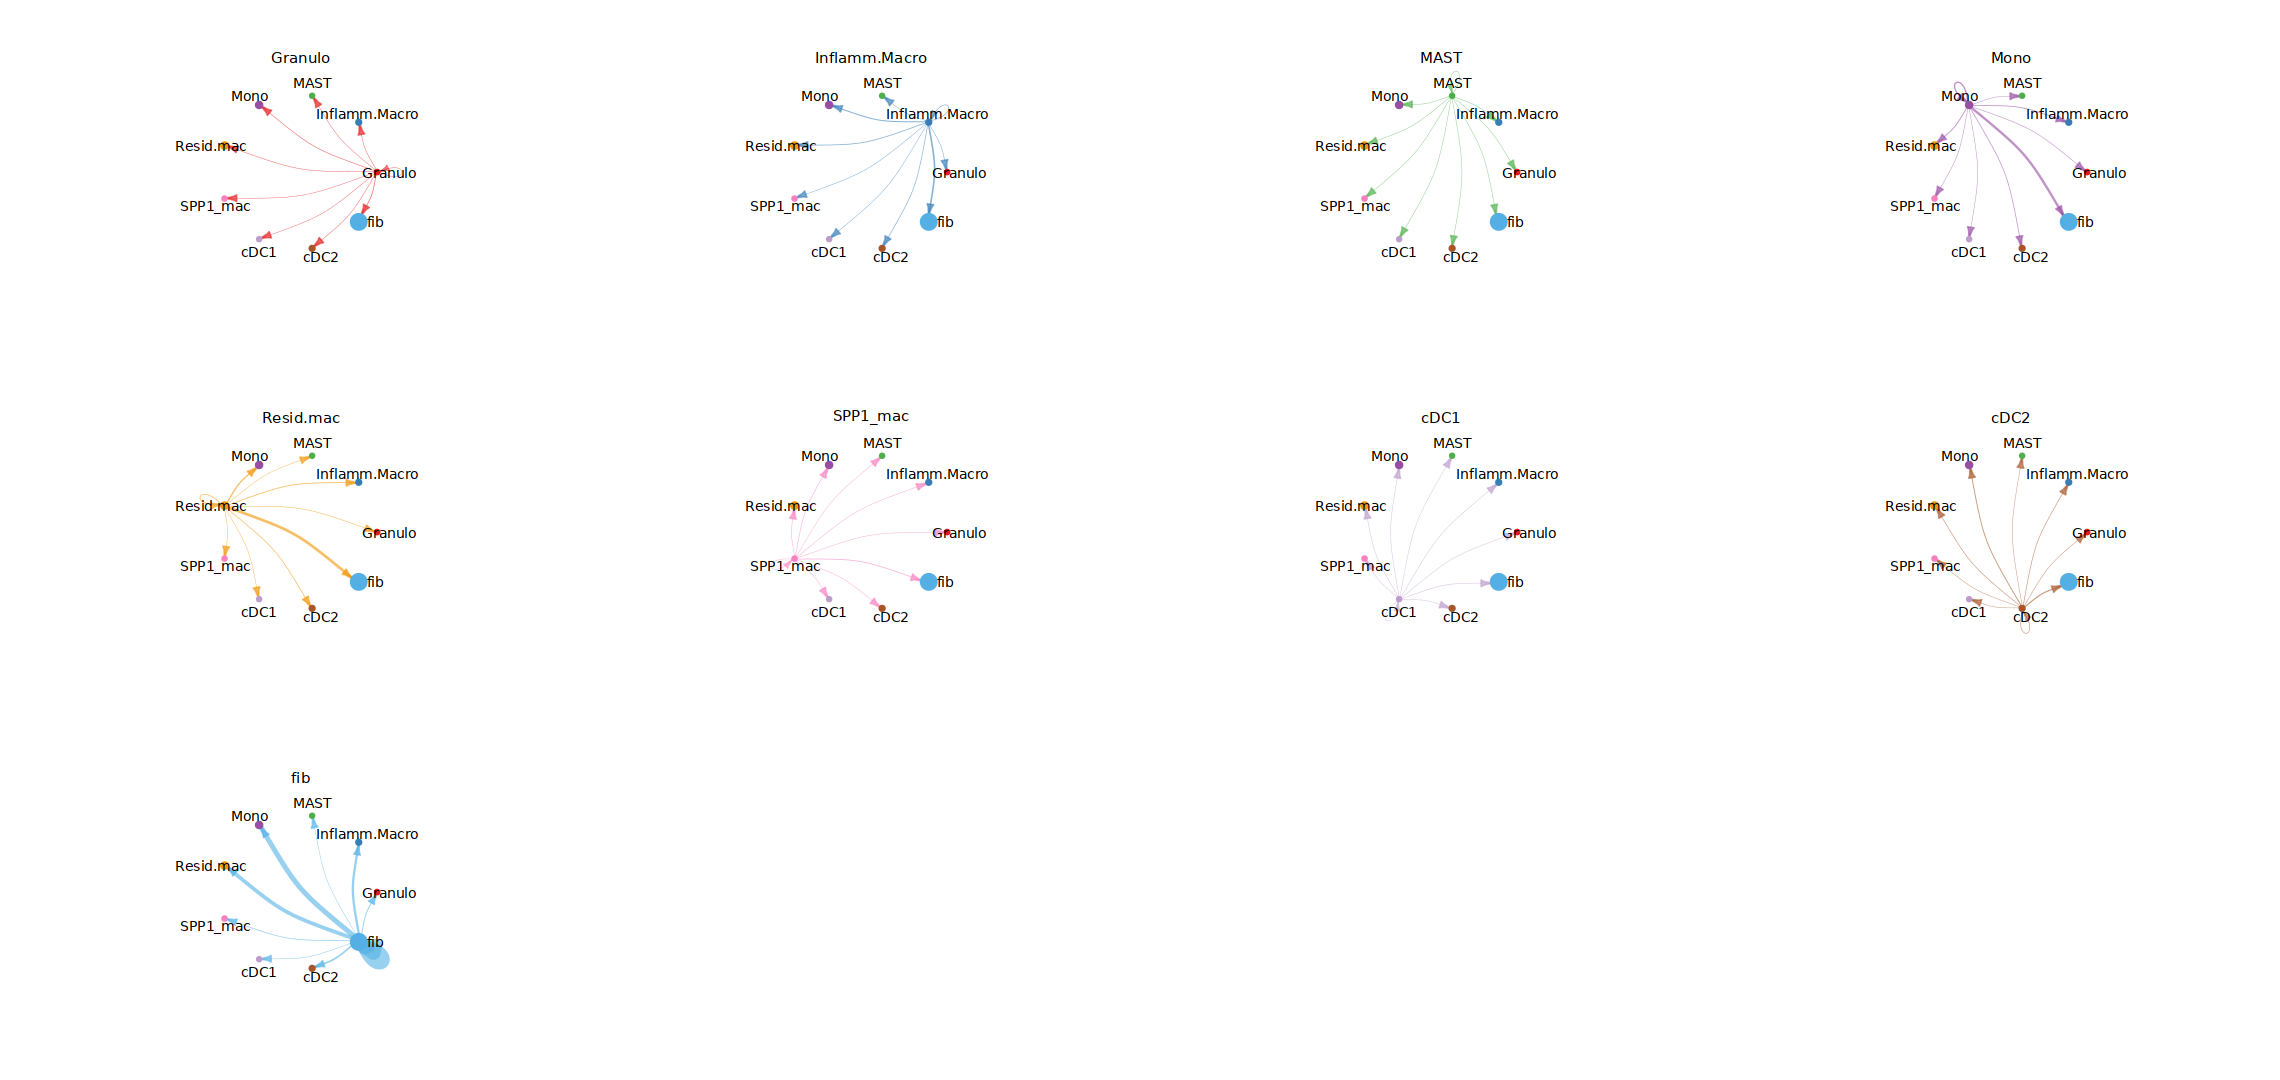

In [44]:
mat <- cellchat@net$weight
par(mfrow = c(3,4), xpd=TRUE)
for (i in 1:nrow(mat)) {
  mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
  mat2[i, ] <- mat[i, ]
  netVisual_circle(mat2, vertex.weight = groupSize, weight.scale = T, edge.weight.max = max(mat), title.name = rownames(mat)[i])
}

In [45]:
pathways.show = cellchat@netP$pathways

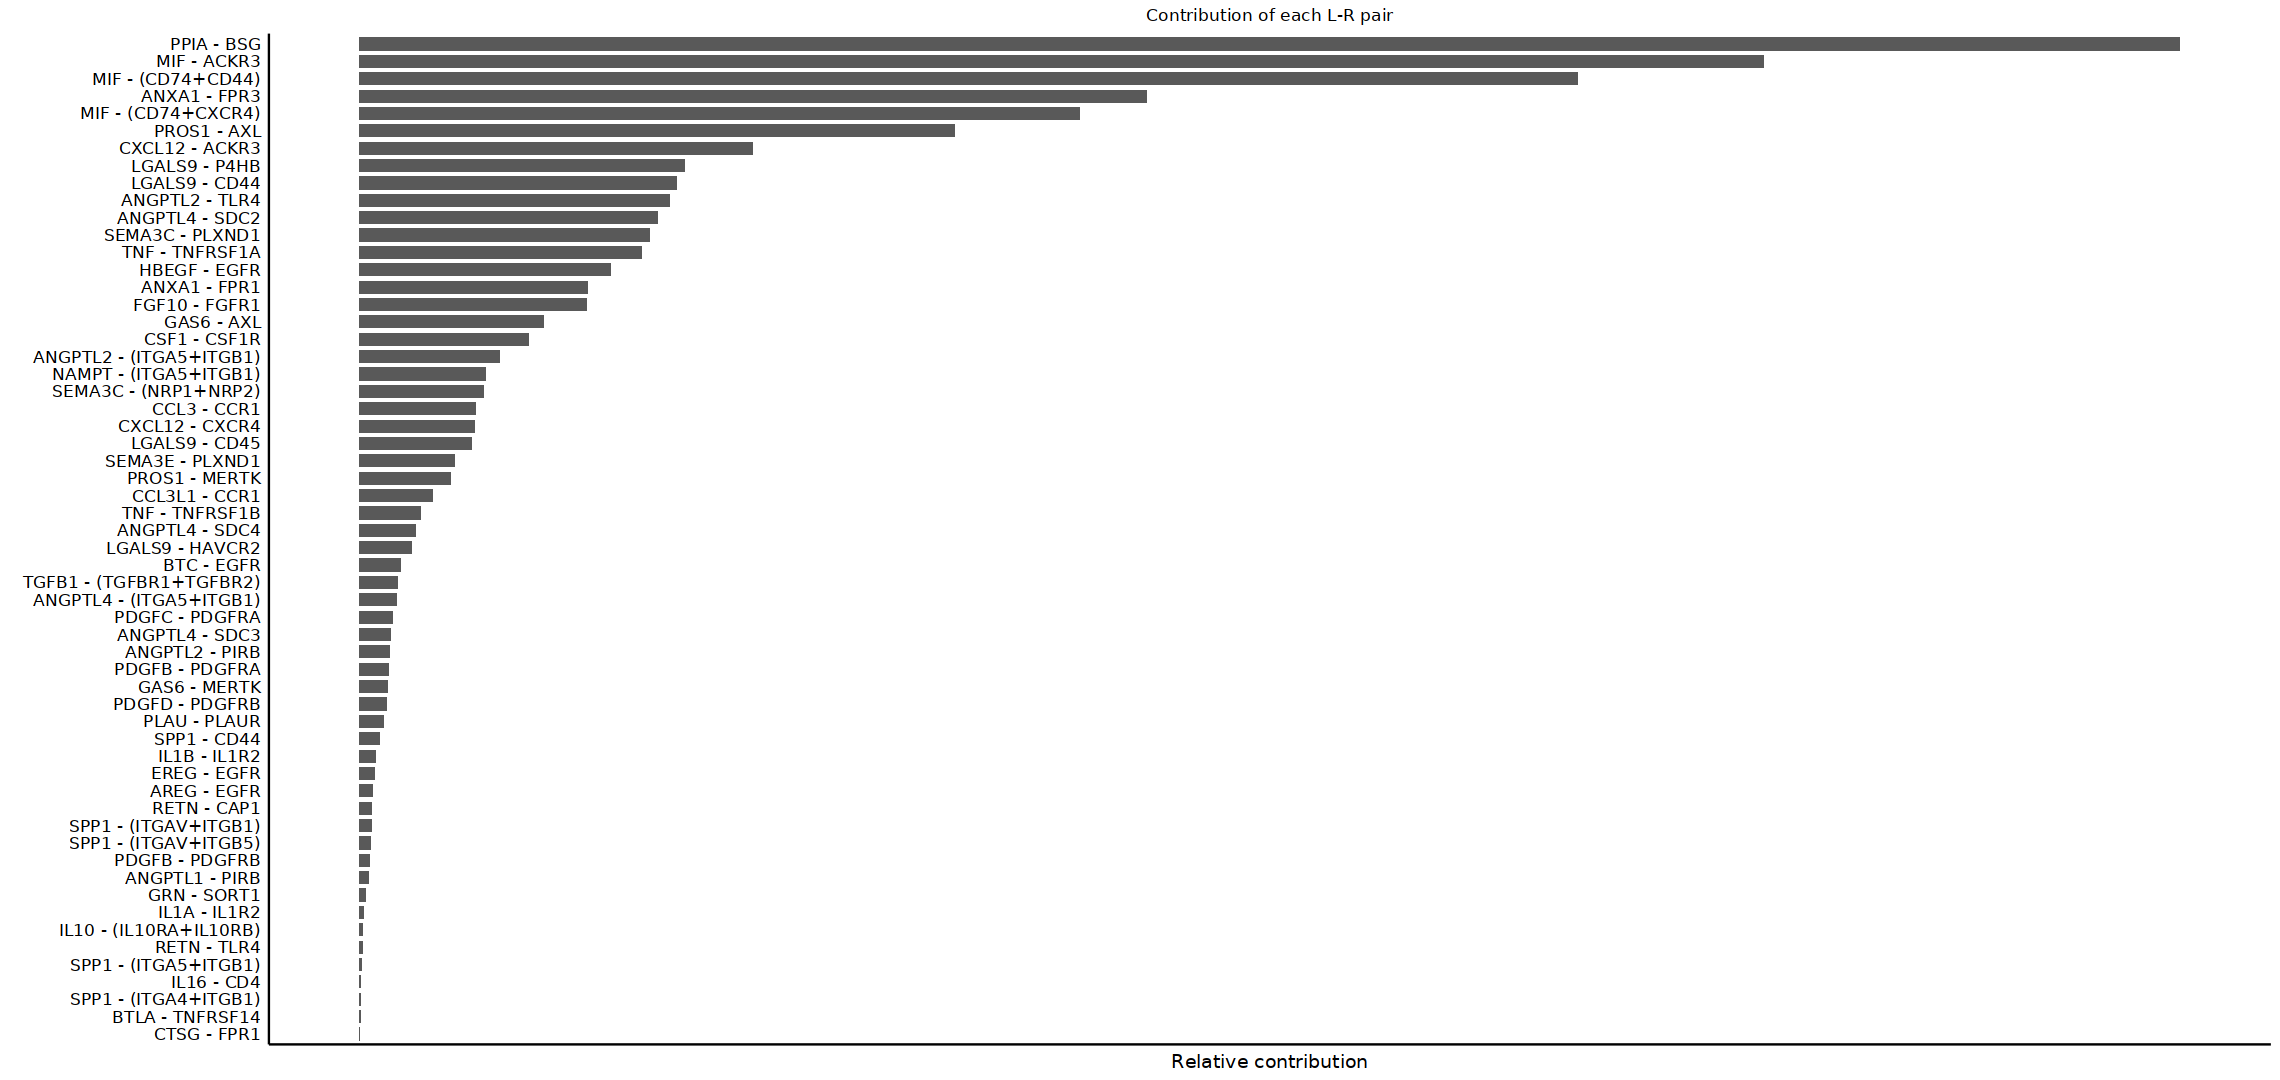

In [46]:
netAnalysis_contribution(cellchat, signaling = pathways.show)

Do heatmap based on a single object 




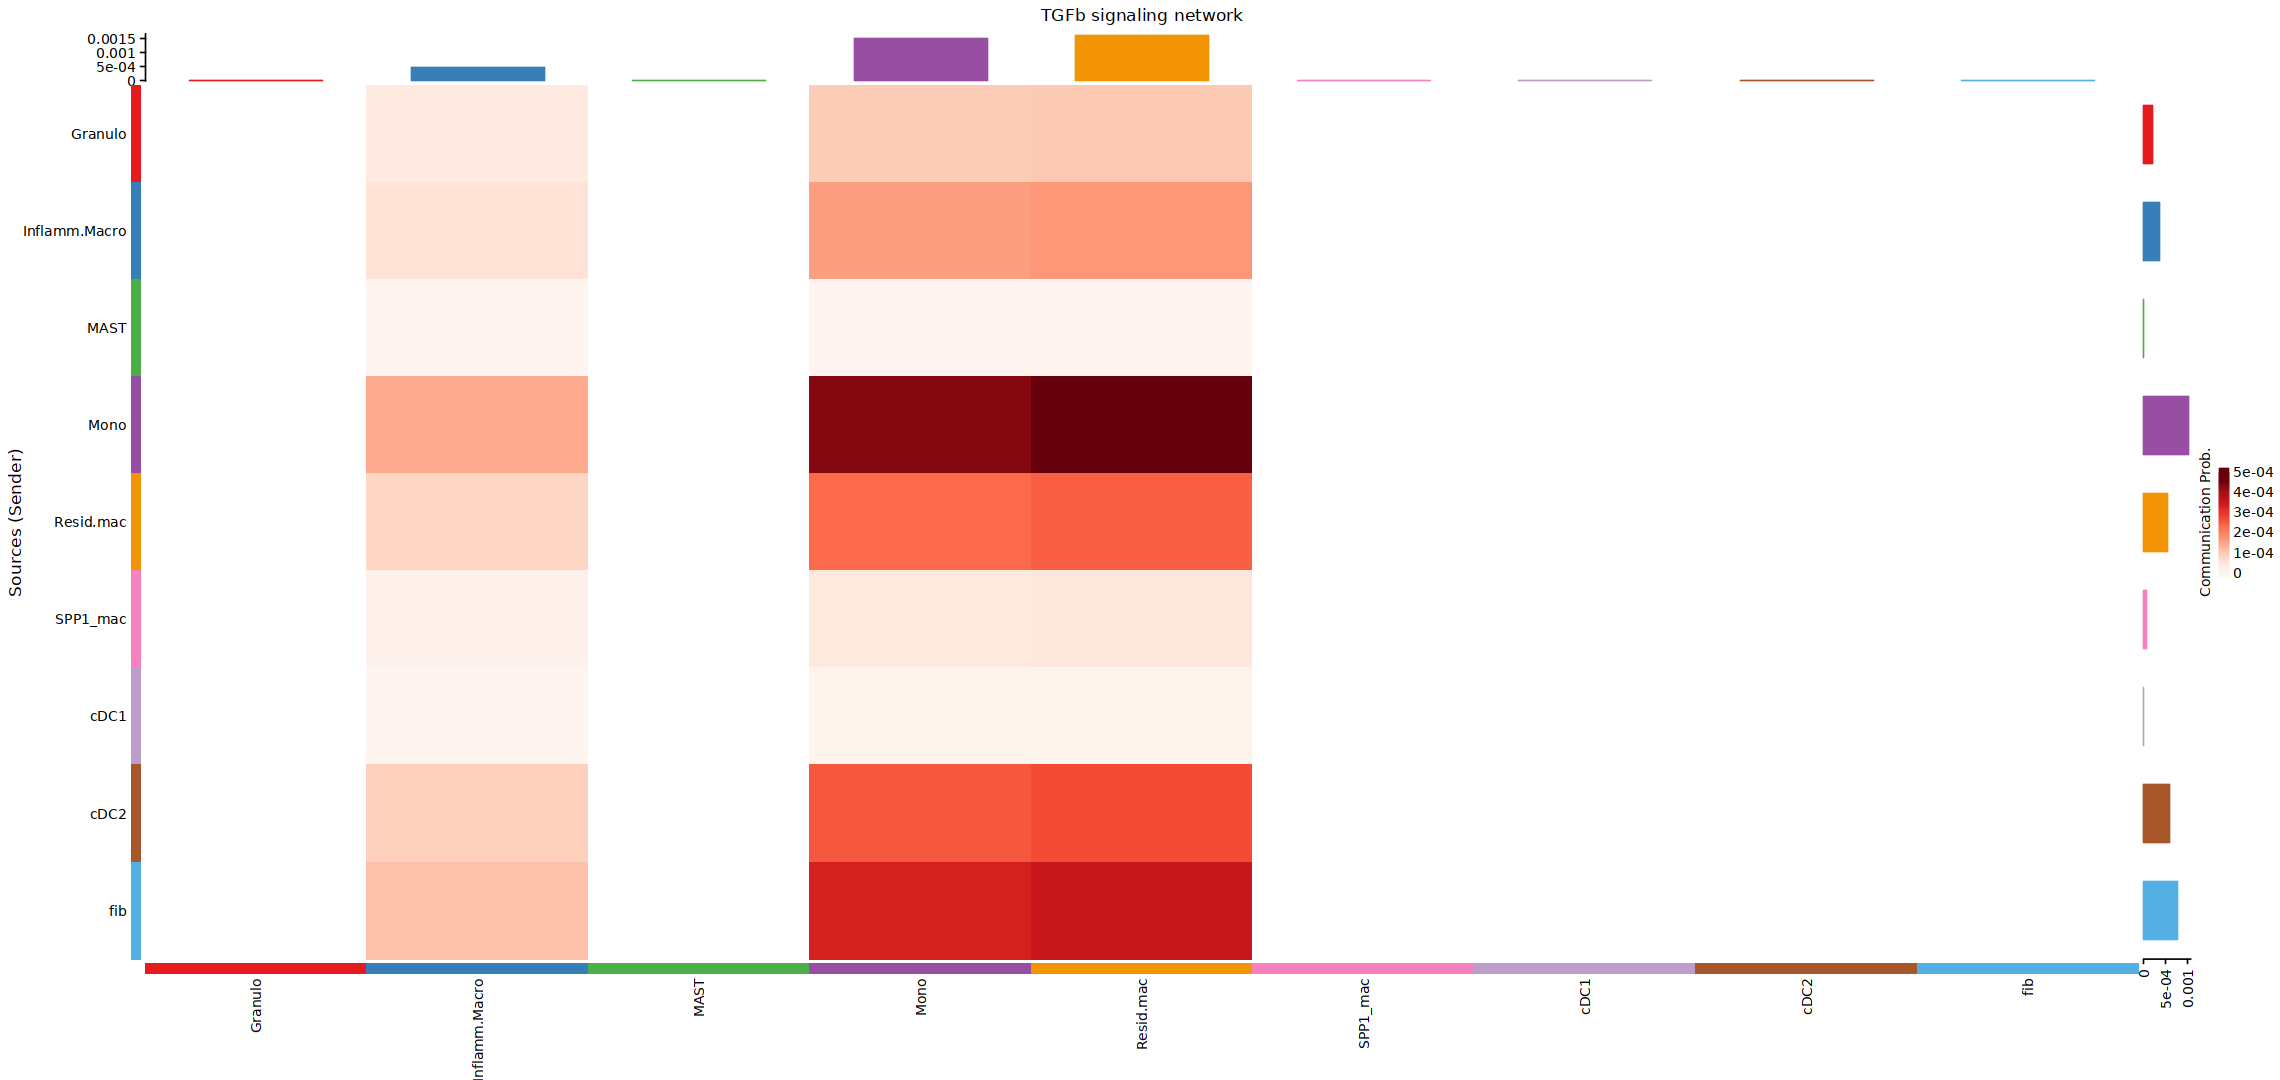

In [47]:
par(mfrow=c(1,1))
netVisual_heatmap(cellchat, signaling = 'TGFb', color.heatmap = "Reds")

In [48]:
pathways.show

[1] "MIF"      "CypA"     "ANNEXIN"  "ANGPTL"   "GALECTIN" "PROS"    
 [7] "SEMA3"    "CXCL"     "TNF"      "EGF"      "FGF"      "GAS"     
[13] "CCL"      "CSF"      "VISFATIN" "PDGF"     "SPP1"     "TGFb"    
[19] "PLAU"     "IL1"      "RESISTIN" "GRN"      "IL10"     "IL16"    
[25] "BTLA"     "CTSG"

In [49]:
options(repr.plot.height = 9,repr.plot.width = 19)

Comparing communications on a single object 




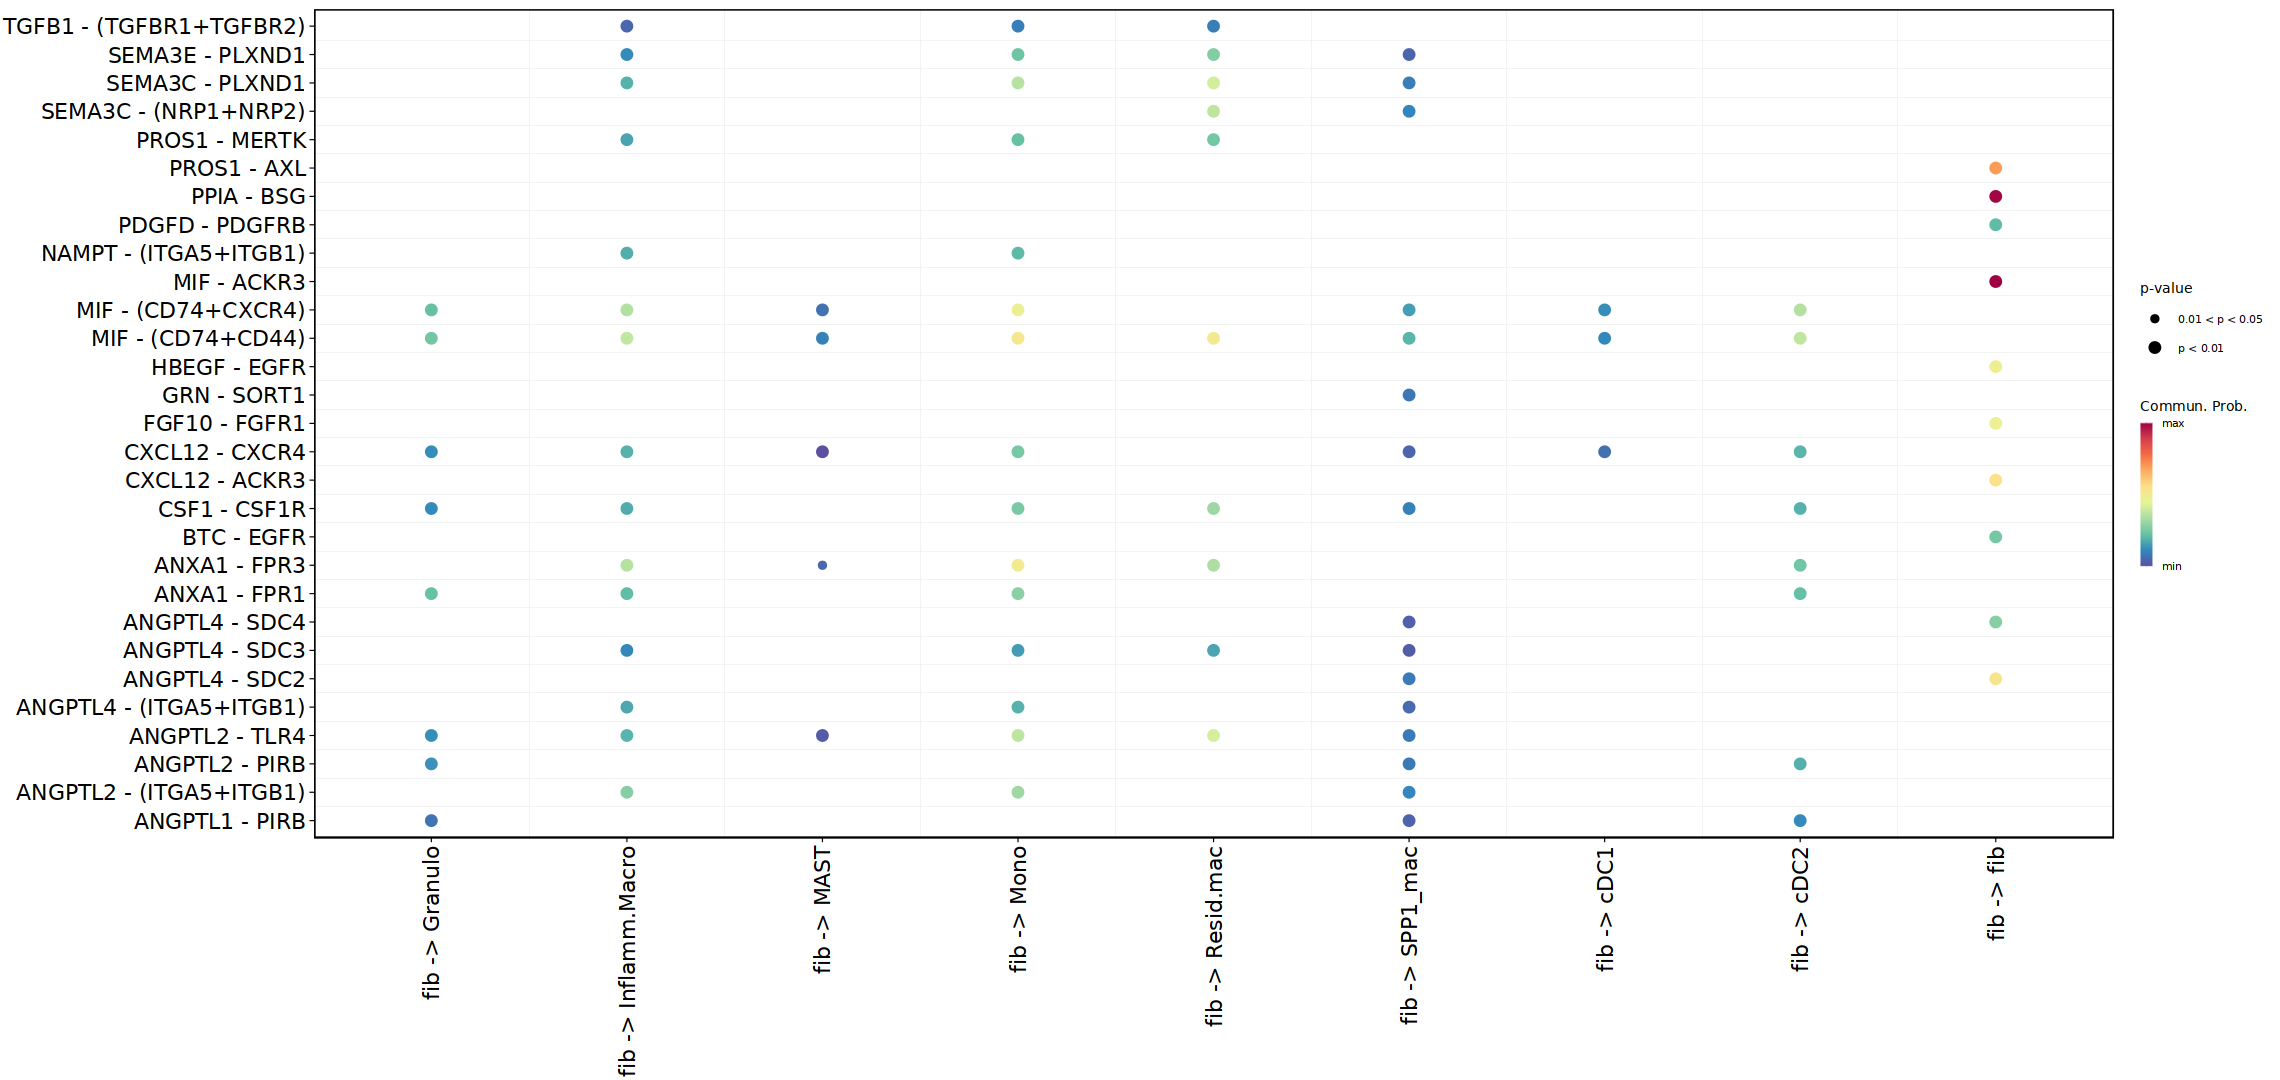

In [51]:
netVisual_bubble(cellchat,sources.use = c(9),font.size = 16,  remove.isolate = FALSE)